# **5. MobileNetV3**

First of all, let's load the required libraries in order to run the code:

In [ ]:
# Base libraries
import os

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

# Tensorflow
import tensorflow.keras as keras
from tensorflow import debugging as tfdbg
from tensorflow import device
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# MobileNet
from tensorflow.keras.applications import MobileNetV3Large, MobileNetV3Small

# Own modules
from src.utils import drop_checkpoints, dataset_stats, plot_metric_curves, extract_features

Now let's see how our data is structured:

In [2]:
# Root folder
base_dir = "./data"

In [3]:
# Train folder
train_dir = os.path.join(base_dir, "train")

# Validation folder
validation_dir = os.path.join(base_dir, "validation")

# Test folder
test_dir = os.path.join(base_dir, "test")

In [4]:
drop_checkpoints(base_dir)

Let's also see how many images there are for each class in the training, validation and test set.

In [5]:
dataset_stats(train_dir, validation_dir, test_dir)

Number of classes: 4
Existing classes: ['Baroque', 'Realism', 'Renaissance', 'Romanticism']

----------------------------------------
Number of images per class and dataset:
----------------------------------------
             Train  Validation  Test
Style                               
Baroque       4000         500   500
Realism       4000         500   500
Renaissance   4000         500   500
Romanticism   4000         500   500


We'll also create the directory, if not created yet, where the models will be saved:

In [6]:
# Create directory where to save the models created
models_dir = "./models"
os.makedirs(models_dir, exist_ok=True)

*Explain dropout and data augmentation, include reference to original paper*

# **5.1 Predictions with the convolutional base and train classifier**

## 5.1.1. Model structure

Let's first create the model structure:

Firstly, let's define the values of some hyperparameters:

In [7]:
# Define some hyperparameters' values

# Input shape
input_shape = (224, 224,  3)

# Batch_size and steps per epoch
training_size = sum([len(file) for path, folder, file in os.walk(train_dir)])
batch_size = 128
steps_per_epoch = training_size // batch_size
print(f"Steps per epoch: {steps_per_epoch}")

Steps per epoch: 125


In [8]:
# conv_base = MobileNetV3Large( 
#     include_top=False,
#     weights="imagenet",
#     input_shape=input_shape,
#     alpha=1.0,
#     pooling=None,
#     dropout_rate=0.2,
# )

conv_base = MobileNetV3Large( 
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
    alpha=1.0,
    pooling=None,
    dropout_rate=0.2,
)

conv_base.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [ ]:
last_layer_shape = (7, 7, 960)
last_layer_size = last_layer_shape[0]*last_layer_shape[1]*last_layer_shape[2]

In [9]:
# Create the model
model = models.Sequential()

model.add(layers.Dense(256, activation='relu', input_dim=last_layer_size))
model.add(layers.Dropout(0.25))
model.add(layers.BatchNormalization())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))

# Output layer
model.add(layers.Dense(4, activation='softmax'))

Once the structure of the base model has been defined, let's see exactly how many parameters it has in order to have a better idea of how flexible this model is:

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               12042496  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                        

We'll use Adam as our optimizer since it is the most popular optimizer right now, as well as versatile (i.e., it can be used in multiple contexts).

In [11]:
# optimizer = optimizers.SGD(learning_rate=0.1, momentum=0.9, weight_decay=0.0001)

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

## 5.1.2. Data preprocessing

In this case, we will include the Data Augmentation step to the model preprocessing step...

In [12]:
# Apply data augmentation to the training set
# https://towardsdatascience.com/exploring-image-data-augmentation-with-keras-and-tensorflow-a8162d89b844
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.8, 1),
    zoom_range=[0.9, 1.1],
    horizontal_flip=True,
    fill_mode='nearest'
    )

# The data augmentation must not be used for the test set!
# All images will be rescaled by 1./255
test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        # All images will be resized to the dimensions specified
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
        )

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        # All images will be resized to the dimensions specified
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
        )

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=input_shape[:2],
        batch_size=40,
        class_mode='categorical',
        shuffle=False
)

Found 16000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.


In [14]:
train_features, train_labels = extract_features(16000, last_layer_shape, conv_base, train_generator, batch_size)
validation_features, validation_labels = extract_features(2000, last_layer_shape, conv_base, validation_generator, batch_size)
test_features, test_labels = extract_features(2000, last_layer_shape, conv_base, test_generator, 40)

# flatten features prior to feeding them to the classifier
train_features = np.reshape(train_features, (16000, last_layer_size))
validation_features = np.reshape(validation_features, (2000, last_layer_size))
test_features = np.reshape(test_features, (2000, last_layer_size))

4/4 [==============================] - 1s 277ms/step


c:\Users\jorge\miniconda3\envs\dl\lib\site-packages\PIL\TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


2/2 [==============================] - 1s 252ms/step


Now let's take a look at the output of one of these generators (for instance, the training one):

In [15]:
for data_batch, labels_batch in train_generator:
    print('Data batch shape:', data_batch.shape)
    print('Labels batch shape:', labels_batch.shape)
    break

Data batch shape: (128, 224, 224, 3)
Labels batch shape: (128, 4)


*We can appreciate that...*

## 5.1.3. Training

Let's train the model:

We use [Early Stopping](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/) to avoid *overfitting*, as well `ModelCheckpoint` to save the best model obtained during training:

In [16]:
# Model name and path
model_path = os.path.join("models", "mobile_frozen_model.h5")

In [17]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(model_path, monitor='val_loss', 
                     mode='min', verbose=1, save_best_only=True)

In [18]:
history = model.fit(
    train_features, train_labels,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=(validation_features, validation_labels),
    validation_steps=20,
    callbacks = [es, mc]
)

Epoch 1/30
125/125 [==============================] - ETA: 0s - loss: 1.4283 - acc: 0.2863
Epoch 1: val_loss improved from inf to 1.33599, saving model to models\mobile_frozen_model.h5
125/125 [==============================] - 31s 216ms/step - loss: 1.4283 - acc: 0.2863 - val_loss: 1.3360 - val_acc: 0.3285
Epoch 2/30
125/125 [==============================] - ETA: 0s - loss: 1.3697 - acc: 0.3038
Epoch 2: val_loss improved from 1.33599 to 1.33338, saving model to models\mobile_frozen_model.h5
125/125 [==============================] - 18s 145ms/step - loss: 1.3697 - acc: 0.3038 - val_loss: 1.3334 - val_acc: 0.3500
Epoch 3/30
125/125 [==============================] - ETA: 0s - loss: 1.3421 - acc: 0.3295
Epoch 3: val_loss improved from 1.33338 to 1.32554, saving model to models\mobile_frozen_model.h5
125/125 [==============================] - 17s 140ms/step - loss: 1.3421 - acc: 0.3295 - val_loss: 1.3255 - val_acc: 0.3710
Epoch 4/30
125/125 [==============================] - ETA: 0s - l

Now let's load the best model found:

In [19]:
# load the saved model
saved_model = load_model(model_path)

## 5.1.4. Validation

Let's plot how the loss and the accuracy from both training and validations sets have evolved during the training process. 

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

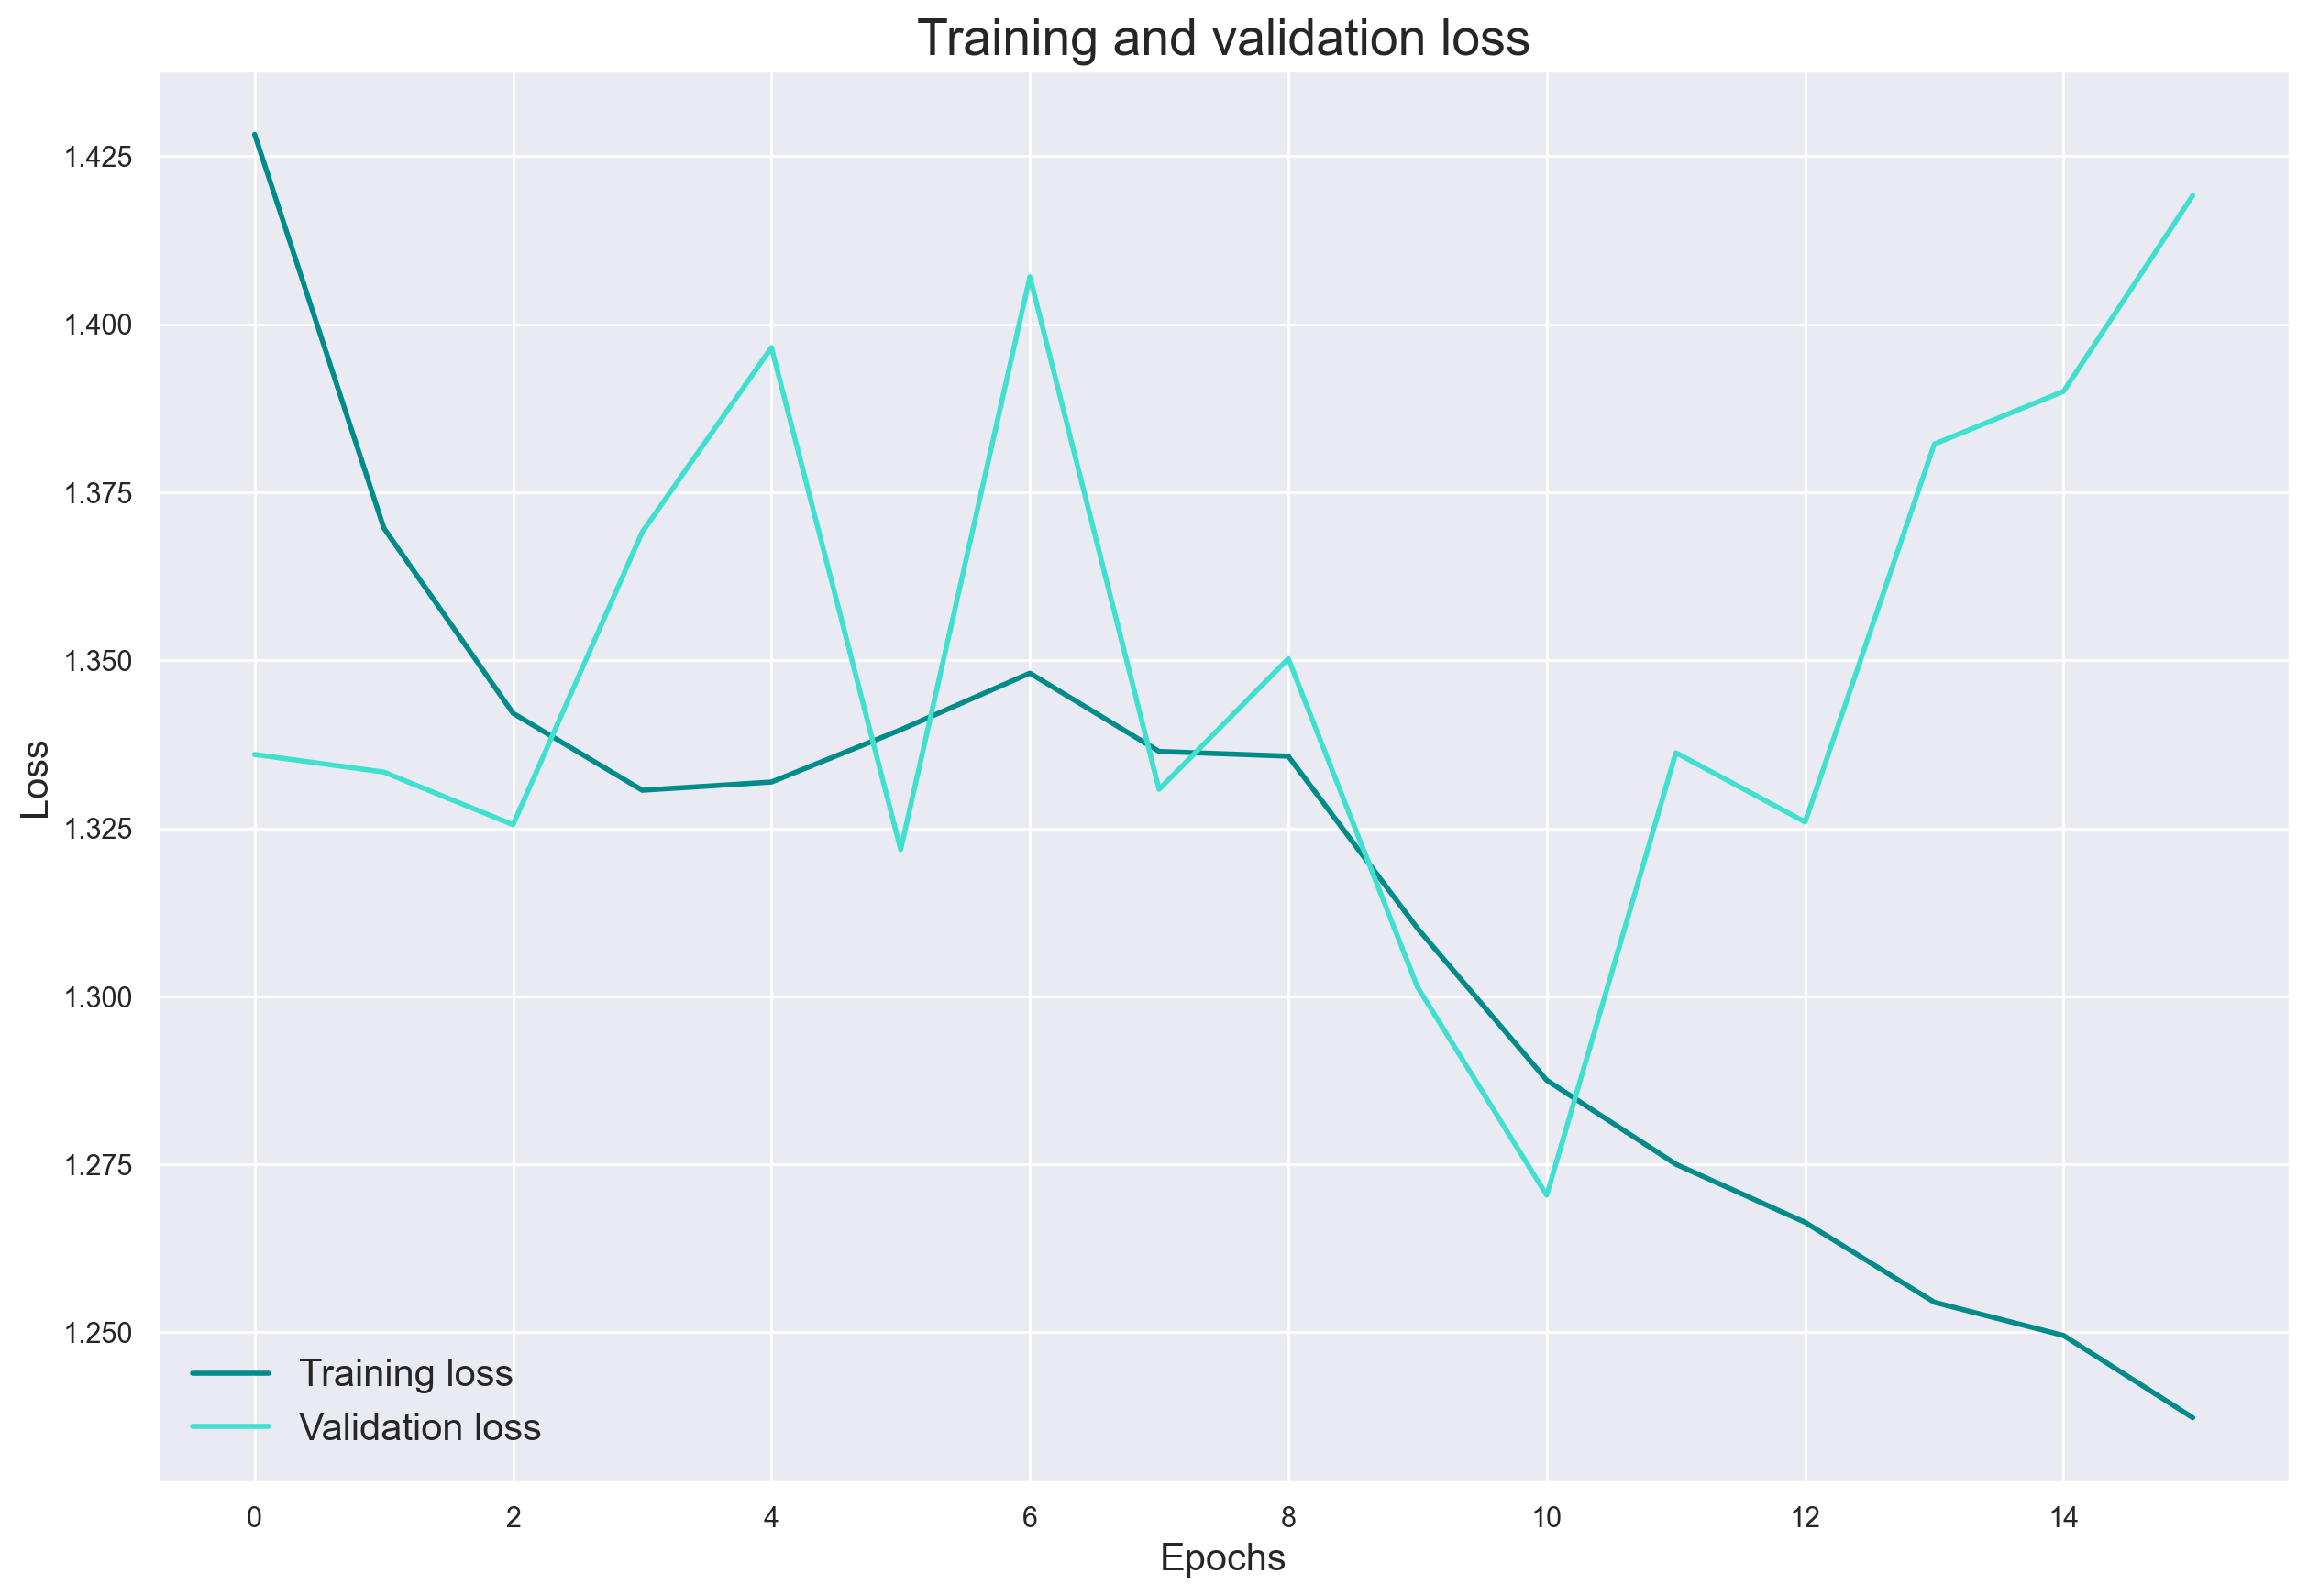

In [21]:
# Plot loss curves
plot_metric_curves(epochs, loss, val_loss, "darkcyan", "turquoise", "Loss")

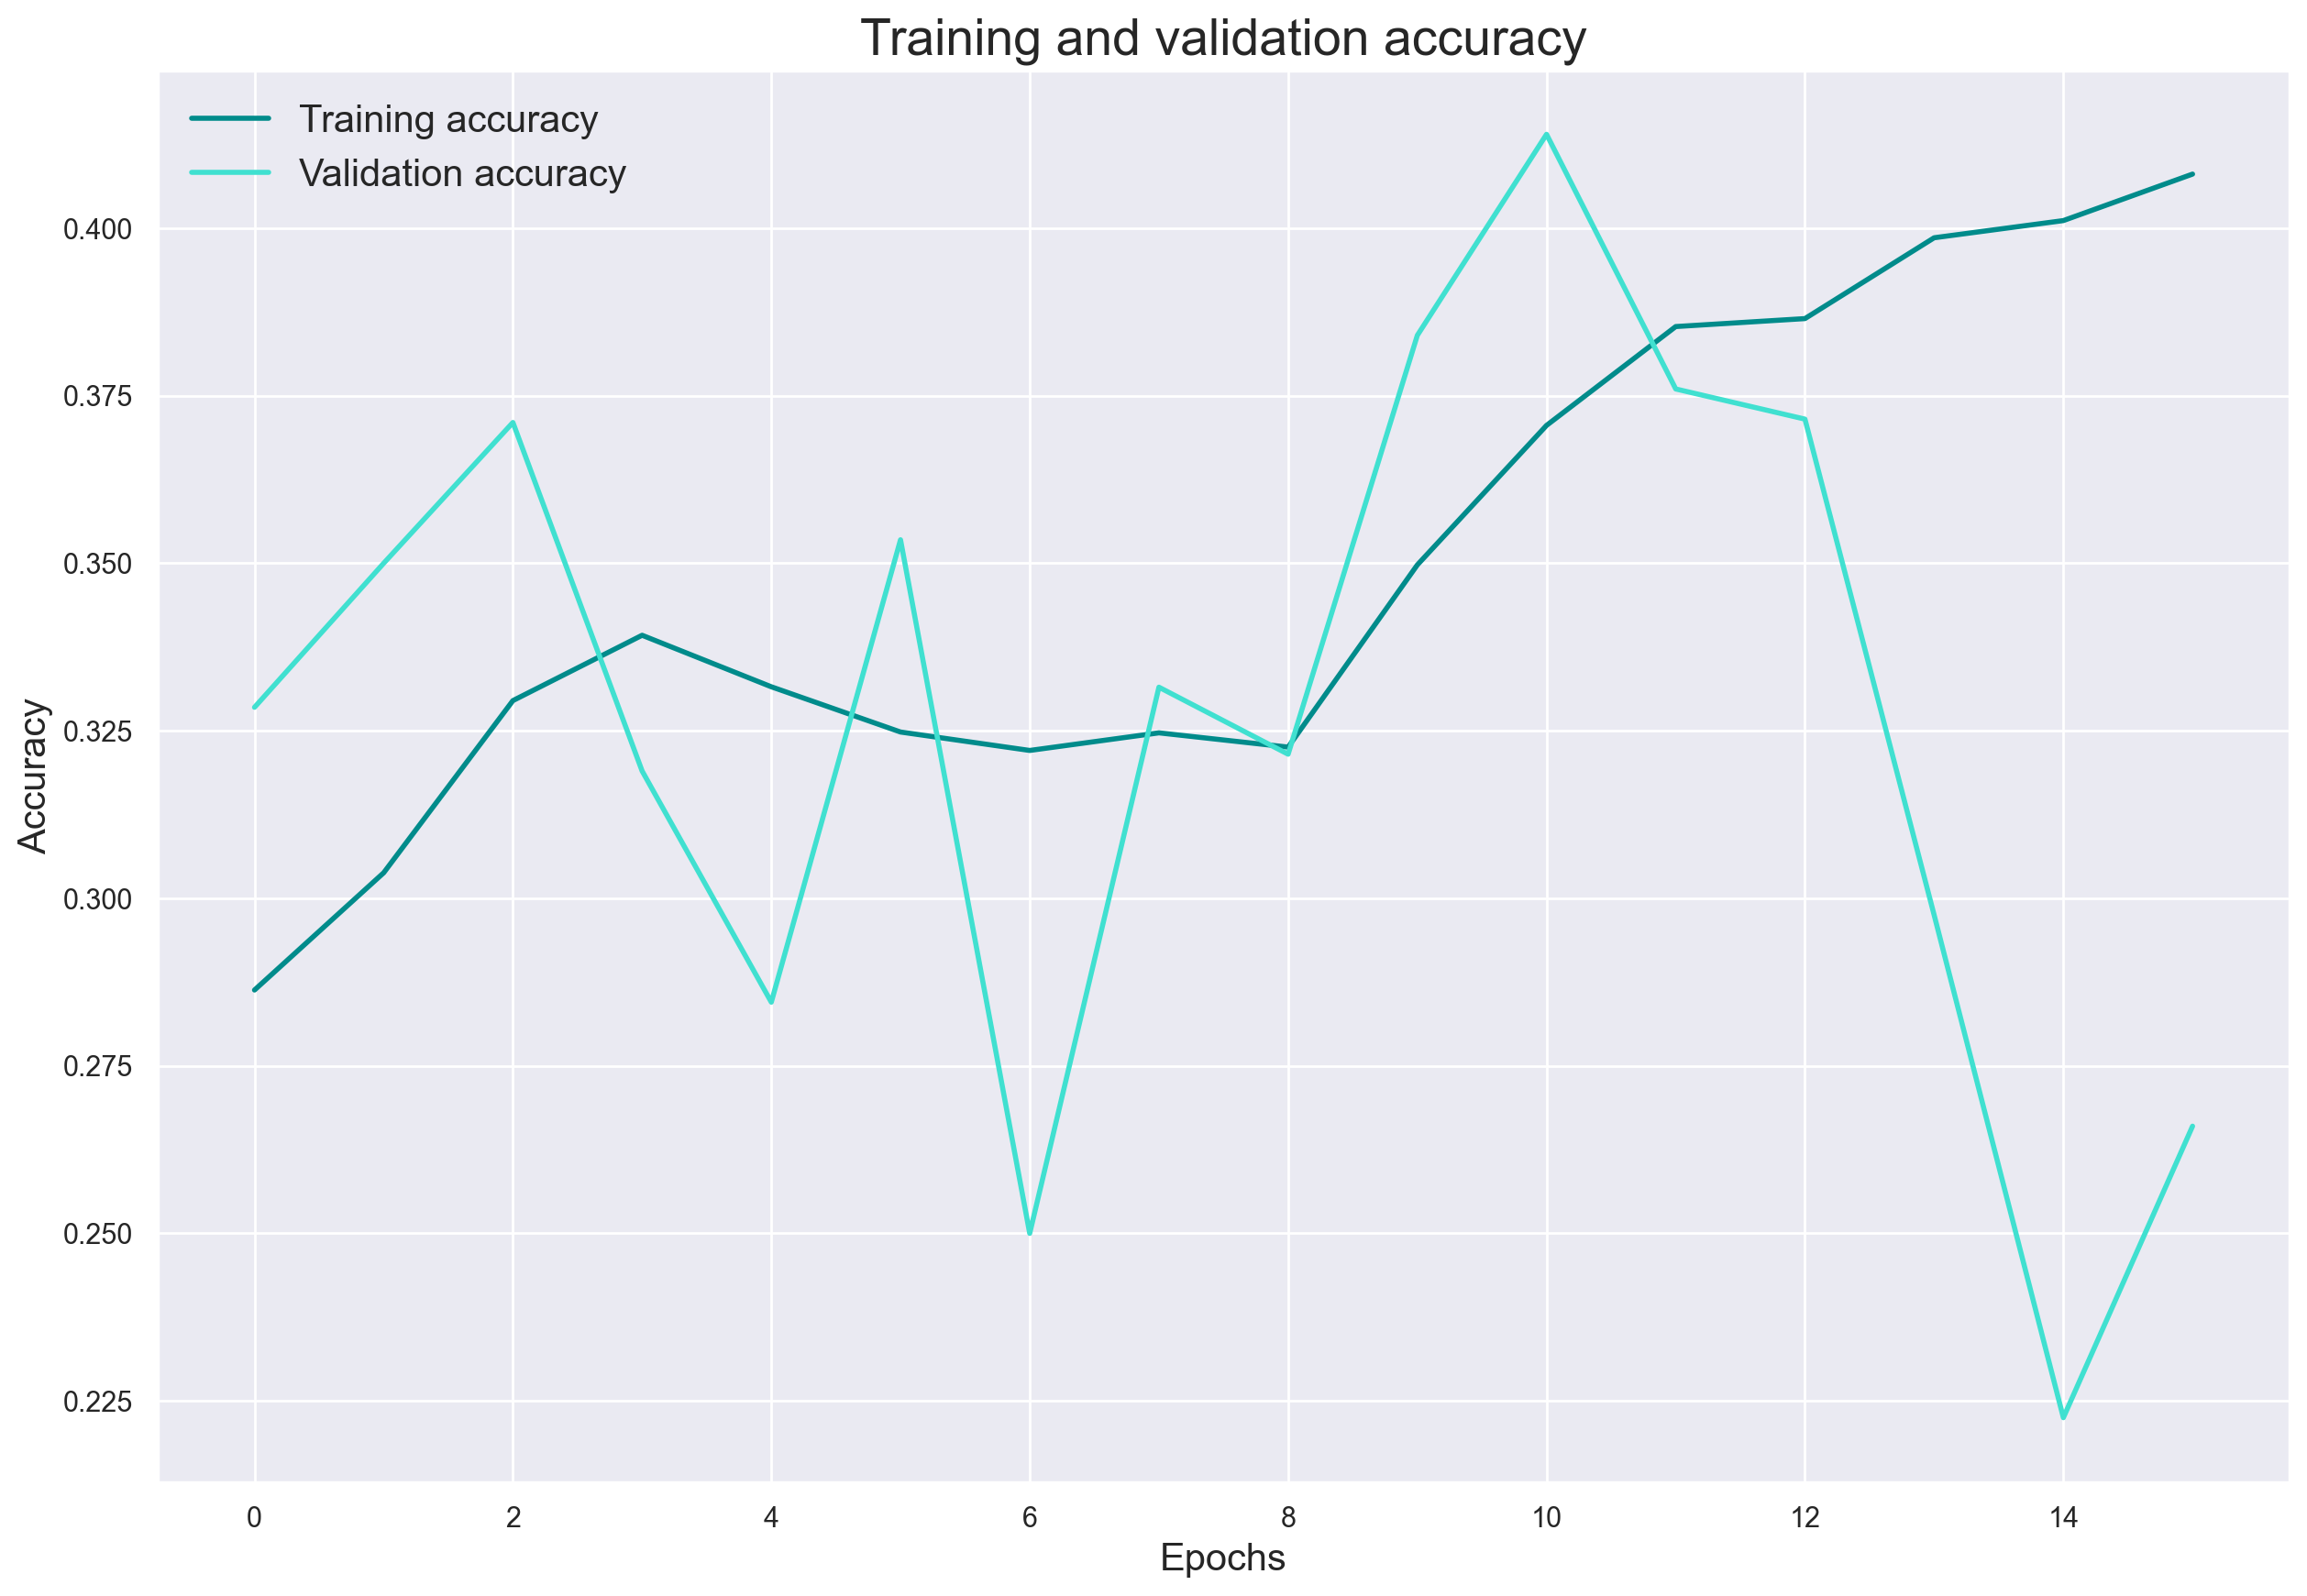

In [22]:
# Plot accuracy curves
plot_metric_curves(epochs, acc, val_acc, "darkcyan", "turquoise", "Accuracy")

In [24]:
saved_model.evaluate(test_features, test_labels)

63/63 [==============================] - 1s 15ms/step - loss: 1.2676 - acc: 0.4170


[1.2675684690475464, 0.4169999957084656]

*Comments about how those metrics have evolved...*